In [ ]:
# Импортируем необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from xgboost import XGBClassifier
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier)
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, KFold, train_test_split, RandomizedSearchCV
import optuna

In [2]:
# Загружаем данные
data = pd.read_csv('data/cc50_data.csv')

Для выполнения задания необходимо создать бинарный столбец, который будет показывать, превышает ли значение CC50 медианное значение по выборке. Этот столбец станет целевой переменной для задачи классификации.

In [3]:
# Вычислим медиану по столбцу CC50_log
si_median = data['CC50_log'].median()

# Создаем бинарный столбец, показывающий, больше ли значение CC50_log медианы
data['CC50_log_binary'] = (data['CC50_log'] > si_median).astype(int)

# Убираем переменную, на основе которой был создан бинарный целевой признак
data = data.drop(columns=['CC50_log'])

Перед тем как приступить к дальнейшей работе, необходимо проверить баланс классов.

In [4]:
# Проверяем баланс классов
print(data['CC50_log_binary'].value_counts())
print(data['CC50_log_binary'].value_counts(normalize=True))

CC50_log_binary
0    466
1    463
Name: count, dtype: int64
CC50_log_binary
0    0.501615
1    0.498385
Name: proportion, dtype: float64


Баланс классов почти идеальный — примерно 50/50, значит с дисбалансом проблем нет.

In [5]:
# Разделяем данные и убираем целевую переменную
X = data.drop(columns=['CC50_log_binary'])
y = data['CC50_log_binary']

In [ ]:
# Разделение данных (70% тренировочные, 30% тестовые)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Тренировочные данные: {X_train.shape[0]}")
print(f"Тестовые данные: {X_test.shape[0]}")

Тренировочные данные: 650
Тестовые данные: 279


In [7]:
# Инициализация моделей со стандартными параметрами
models = {
    'XGBoost': XGBClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'HistGradient Boosting': HistGradientBoostingClassifier(random_state=42, loss='log_loss'),
    'Extra Trees': ExtraTreesClassifier(random_state=42),
}

In [8]:
# Функция для оценки моделей
def evaluate_model(model, X_train, y_train, X_test, y_test):
    """Оценивает классификационную модель и возвращает accuracy и F1-score"""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return {
        'Accuracy': round(accuracy_score(y_test, y_pred), 4),
        'F1-score': round(f1_score(y_test, y_pred), 4),
        'Precision': round(precision_score(y_test, y_pred), 4),
        'Recall': round(recall_score(y_test, y_pred), 4),
    }

In [9]:
# Оценка базовых моделей (без подбора параметров)
base_results = []
for name, model in models.items():
    metrics = evaluate_model(model, X_train, y_train, X_test, y_test)
    base_results.append({
        'Model': name,
        **metrics,
        'Hyperparametres': False
    })
    
base_results = pd.DataFrame(base_results)
display(base_results.sort_values('Accuracy', ascending=False))

,Model,Accuracy,F1-score,Precision,Recall,Hyperparametres
0,XGBoost,0.8315,0.8142,0.8306,0.7984,False
2,CatBoost,0.8315,0.8097,0.8475,0.7752,False
3,Gradient Boosting,0.8208,0.7967,0.8376,0.7597,False
4,HistGradient Boosting,0.8208,0.7967,0.8376,0.7597,False
5,Extra Trees,0.7993,0.7846,0.7786,0.7907,False
1,Random Forest,0.7957,0.7765,0.7857,0.7674,False


На начальном этапе модели обучались без настройки гиперпараметров. Лучший показатель точности показали модели XGBoost и CatBoost, обе с результатом 0.8315, что говорит об их высокой способности классифицировать превышение медианного значения CC50. Модель Random Forest показала наихудшие результаты по точности (Accuracy = 0.7957) и F1-score (0.7765), что требует дополнительной настройки.

In [ ]:
"""
Определяем словарь param_grid с диапазонами гиперпараметров для каждой модели.
- Числовые параметры задаются как кортеж (min, max) и:
  - преобразуются в списки при использовании RandomizedSearchCV,
  - или напрямую используются в Optuna для проб в указанных границах.
- Категориальные параметры задаются списками (например: ['sqrt', 'log2', None]).
Словарь используется для автоматического подбора параметров с помощью разных стратегий оптимизации.
"""

param_grid = {
    'XGBoost': {
        'n_estimators': (100, 500),
        'max_depth': (3, 11),
        'learning_rate': (0.01, 0.3),
        'subsample': (0.5, 1.0),
        'colsample_bytree': (0.5, 1.0),
        'gamma': (0.0, 5.0),
        'min_child_weight': (1, 10),
    },

    'Random Forest': {
        'n_estimators': (100, 300),
        'max_depth': (4, 20),
        'min_samples_split': (2, 18),
        'min_samples_leaf': (1, 18),
        'max_features': ['sqrt', 'log2', None],
        'bootstrap': [True],
    },

    'CatBoost': {
        'iterations': (150, 1000),
        'depth': (4, 12),
        'learning_rate': (0.01, 0.3),
        'l2_leaf_reg': (1, 10),
        'border_count': [64, 128, 255],
        'bagging_temperature': (0.0, 1.0),
        'verbose': [False],
    },

    'Gradient Boosting': {
        'n_estimators': (100, 300),
        'learning_rate': (0.01, 0.3),
        'max_depth': (3, 10),
        'min_samples_split': (2, 18),
        'min_samples_leaf': (1, 18),
        'max_features': ['sqrt', 'log2', None],
        'subsample': (0.5, 1.0),
    },

    'HistGradient Boosting': {
        'max_iter': (100, 300),
        'learning_rate': (0.01, 0.3),
        'max_depth': (3, 11),
        'min_samples_leaf': (1, 25),
        'l2_regularization': (0.0, 1.0),
        'max_bins': [64, 128, 255],
    },

    'Extra Trees': {
        'n_estimators': (100, 300),
        'max_depth': (4, 20),
        'min_samples_split': (2, 18),
        'min_samples_leaf': (1, 18),
        'max_features': ['sqrt', 'log2', None],
        'bootstrap': [True],
    }
}

In [ ]:
def convert_grid_for_random_search(grid, n_points=3):
    """
    Преобразует сетку гиперпараметров с диапазонами (кортежи) в списки значений для RandomizedSearchCV.
    - Если параметр задан диапазоном (tuple), генерирует n_points равномерно распределённых значений.
    - Если параметр уже список, оставляет без изменений.
    """
    rs_grid = {}
    for param, vals in grid.items():
        if isinstance(vals, tuple):
            # Диапазон: генерируем n_points значений (int или float)
            if all(isinstance(v, int) for v in vals):
                rs_grid[param] = list(np.linspace(vals[0], vals[1], n_points, dtype=int))
            else:
                rs_grid[param] = list(np.linspace(vals[0], vals[1], n_points))
        elif isinstance(vals, list):
            rs_grid[param] = vals
        else:
            raise ValueError(f"Unknown param type for {param}: {vals}")
    return rs_grid

# Перебор моделей и подбор гиперпараметров с RandomizedSearchCV, используя преобразованную сетку параметров
tuned_results = []
for name in models.keys():
    # Преобразуем сетку из диапазонов в списки для RandomizedSearchCV
    rs_params = convert_grid_for_random_search(param_grid[name], n_points=3)

    search = RandomizedSearchCV(
        estimator=models[name],
        param_distributions=rs_params,
        n_iter=20,
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train, y_train)

    metrics = evaluate_model(search.best_estimator_, X_train, y_train, X_test, y_test)
    tuned_results.append({
        'Model': name,
        **metrics,
        'Hyperparametres': True
    })

tuned_results = pd.DataFrame(tuned_results)
display(tuned_results.sort_values('Accuracy', ascending=False))

,Model,Accuracy,F1-score,Precision,Recall,Hyperparametres
2,CatBoost,0.8244,0.8000,0.8448,0.7597,True
0,XGBoost,0.8208,0.8016,0.8211,0.7829,True
3,Gradient Boosting,0.8136,0.7886,0.8291,0.7519,True
5,Extra Trees,0.8100,0.7819,0.8333,0.7364,True
1,Random Forest,0.8029,0.7791,0.8083,0.7519,True
4,HistGradient Boosting,0.7957,0.7397,0.9000,0.6279,True


После настройки гиперпараметров лучшие показатели точности сохранила модель CatBoost (Accuracy = 0.8244), а XGBoost немного снизил точность (0.8208). Random Forest улучшил некоторые метрики, но остался ниже лидеров. Примечательно снижение Recall у HistGradient Boosting (0.6279).

In [12]:
# Объединение результатов
all_results = pd.concat([base_results, tuned_results])

# Вывод таблицы
display(all_results.sort_values('Accuracy', ascending=False))

,Model,Accuracy,F1-score,Precision,Recall,Hyperparametres
0,XGBoost,0.8315,0.8142,0.8306,0.7984,False
2,CatBoost,0.8315,0.8097,0.8475,0.7752,False
2,CatBoost,0.8244,0.8000,0.8448,0.7597,True
3,Gradient Boosting,0.8208,0.7967,0.8376,0.7597,False
4,HistGradient Boosting,0.8208,0.7967,0.8376,0.7597,False
0,XGBoost,0.8208,0.8016,0.8211,0.7829,True
3,Gradient Boosting,0.8136,0.7886,0.8291,0.7519,True
5,Extra Trees,0.8100,0.7819,0.8333,0.7364,True
1,Random Forest,0.8029,0.7791,0.8083,0.7519,True
5,Extra Trees,0.7993,0.7846,0.7786,0.7907,False


Агрегированная таблица показывает, что модели XGBoost и CatBoost демонстрируют лучшие метрики до настройки, а после оптимизации CatBoost сохраняет высокие показатели. Оптимизация позволяет сохранить баланс между Precision и Recall, однако у некоторых моделей, например HistGradient Boosting, появляется заметное снижение Recall.

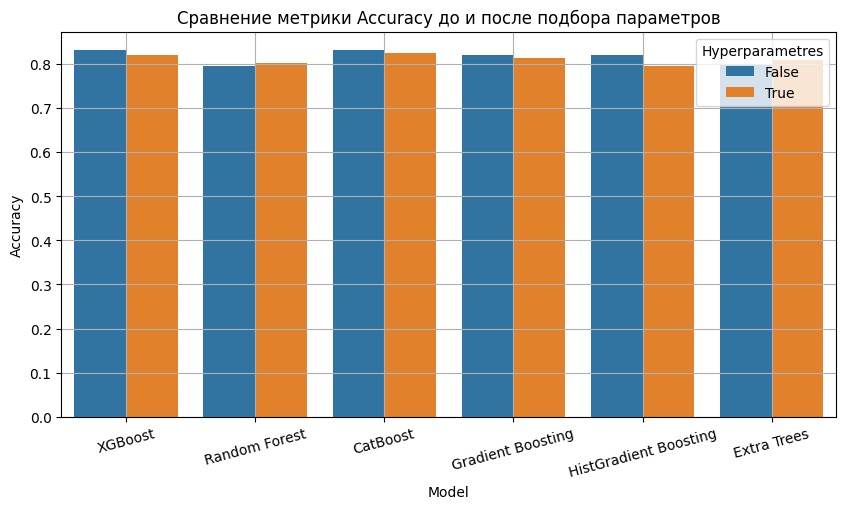

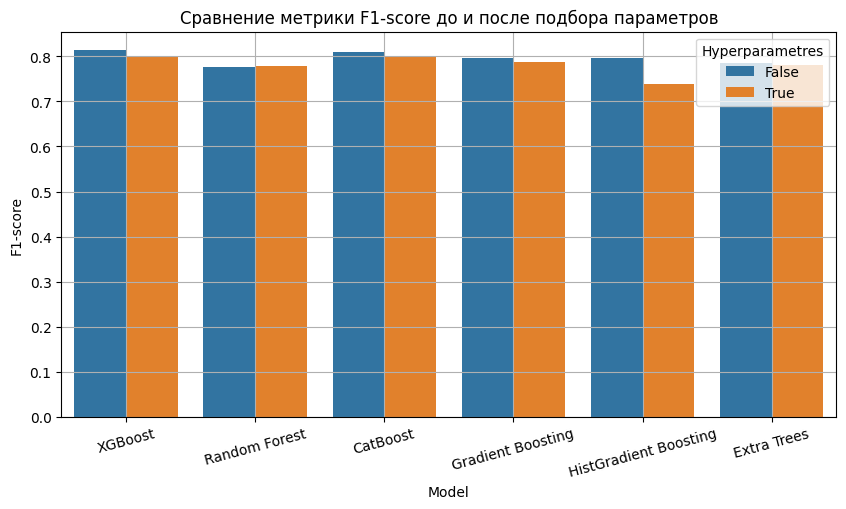

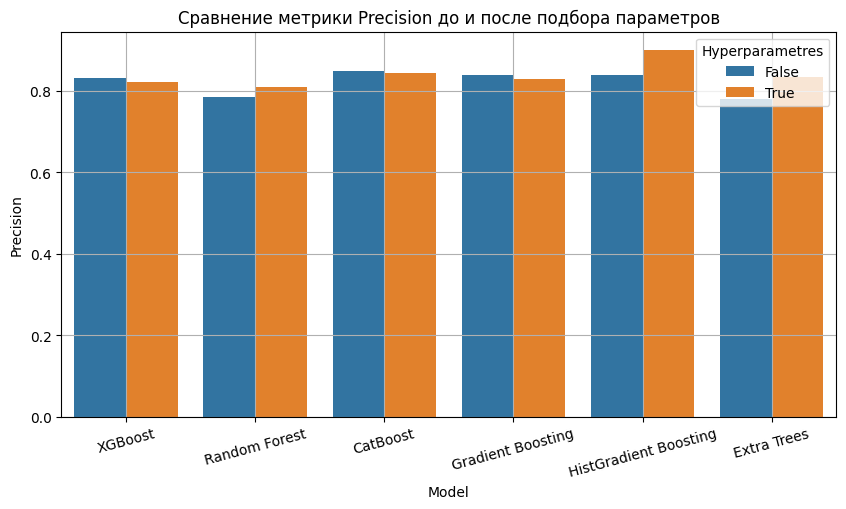

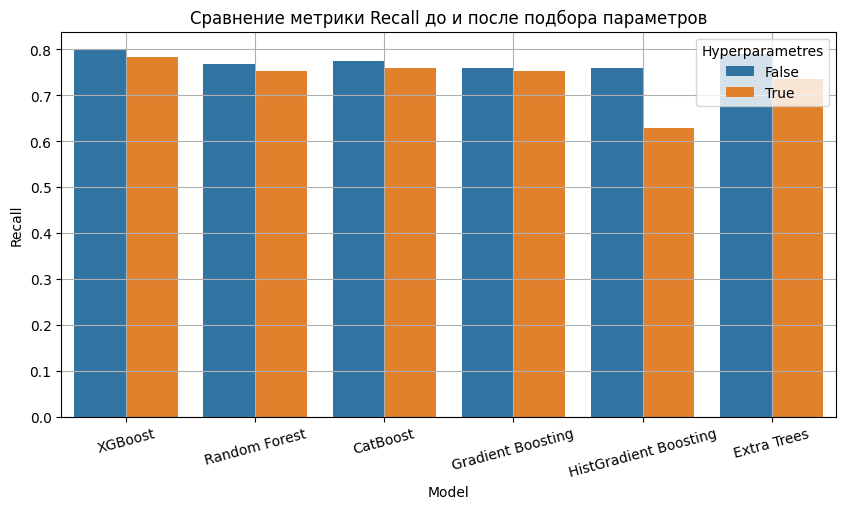

In [ ]:
# Визуализация сравнения моделей по метрикам (Accuracy, F1-score, Precision, Recall) до и после подбора гиперпараметров
metrics_to_plot = ['Accuracy', 'F1-score', 'Precision', 'Recall']

for metric in metrics_to_plot:
    plt.figure(figsize=(10, 5))
    sns.barplot(data=all_results, x='Model', y=metric, hue='Hyperparametres')
    plt.title(f'Сравнение метрики {metric} до и после подбора параметров')
    plt.ylabel(metric)
    plt.xticks(rotation=15)
    plt.grid(True)
    plt.show()


In [ ]:
# Анализ результатов: определение лучших и худших моделей по метрикам, выбор модели с минимальным RMSE и выявление моделей, у которых тюнинг не дал улучшений
tuned_only = all_results[all_results['Hyperparametres'] == True].copy()
baseline = all_results[all_results['Hyperparametres'] == False].copy()

# Модель, выбранная для дальнейшей оптимизации
chosen_model = all_results.sort_values('Accuracy', ascending=False).iloc[0]['Model']

# Проход по метрикам
for metric in ['Accuracy', 'F1-score', 'Precision', 'Recall']:
    print(f"\nМетрика: {metric}")

    ascending = False

    best_model = all_results.sort_values(metric, ascending=ascending).iloc[0]
    worst_model = all_results.sort_values(metric, ascending=not ascending).iloc[0]

    print(f"Лучшая модель: **{best_model['Model']}** → {metric} = {best_model[metric]:.4f}")
    print(f"Худшая модель: **{worst_model['Model']}** → {metric} = {worst_model[metric]:.4f}")

    # Сравнение тюнингованных с базовыми версиями
    merged = tuned_only.merge(
        baseline,
        on='Model',
        suffixes=('_tuned', '_base')
    ).drop_duplicates('Model')

    stagnant = merged[merged[f'{metric}_tuned'] <= merged[f'{metric}_base']]['Model'].tolist()

    if stagnant:
        print(f"Без улучшений или хуже: {', '.join(sorted(set(stagnant)))}")


Метрика: Accuracy
Лучшая модель: **XGBoost** → Accuracy = 0.8315
Худшая модель: **Random Forest** → Accuracy = 0.7957
Без улучшений или хуже: CatBoost, Gradient Boosting, HistGradient Boosting, XGBoost

Метрика: F1-score
Лучшая модель: **XGBoost** → F1-score = 0.8142
Худшая модель: **HistGradient Boosting** → F1-score = 0.7397
Без улучшений или хуже: CatBoost, Extra Trees, Gradient Boosting, HistGradient Boosting, XGBoost

Метрика: Precision
Лучшая модель: **HistGradient Boosting** → Precision = 0.9000
Худшая модель: **Extra Trees** → Precision = 0.7786
Без улучшений или хуже: CatBoost, Gradient Boosting, XGBoost

Метрика: Recall
Лучшая модель: **XGBoost** → Recall = 0.7984
Худшая модель: **HistGradient Boosting** → Recall = 0.6279
Без улучшений или хуже: CatBoost, Extra Trees, Gradient Boosting, HistGradient Boosting, Random Forest, XGBoost


In [ ]:
# Выбираем лучшую модель
best_model_name = all_results.sort_values('Accuracy', ascending=False).iloc[0]['Model']
print(f"Лучшая модель: {best_model_name}")

model_class = models[best_model_name]
param_space = param_grid[best_model_name]

def objective(trial):
    params = {}
    for param, values in param_space.items():
        # Если диапазон (tuple), предполагаем [min, max]
        if isinstance(values, tuple) and len(values) == 2:
            low, high = values
            if isinstance(low, int) and isinstance(high, int):
                params[param] = trial.suggest_int(param, low, high)
            else:
                params[param] = trial.suggest_float(param, low, high)
        # Если список, то категориальный параметр
        elif isinstance(values, list):
            # Если это список с bool или str/None - categorical
            if all(isinstance(v, bool) for v in values) or all(isinstance(v, (str,type(None))) for v in values):
                params[param] = trial.suggest_categorical(param, values)
            # Если числа — тоже categorical (например дискретные значения)
            elif all(isinstance(v, (int,float)) for v in values):
                params[param] = trial.suggest_categorical(param, values)
            else:
                raise ValueError(f"Unsupported list param type for '{param}': {values}")
        else:
            raise ValueError(f"Unsupported param format for '{param}': {values}")

    params['random_state'] = 42

    model = model_class.__class__(**params)
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    accuracy = cross_val_score(model, X_train, y_train,
                               scoring='accuracy', cv=cv, n_jobs=-1).mean()
    return accuracy

print(f"\nЗапуск Optuna для {best_model_name}...")
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=100, show_progress_bar=True)

print(f"\nЛучшие параметры:")
print(study.best_params)

final_model = model_class.__class__(**study.best_params, random_state=42)
final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)

final_accuracy = accuracy_score(y_test, y_pred)
final_f1 = f1_score(y_test, y_pred)
final_precision = precision_score(y_test, y_pred)
final_recall = recall_score(y_test, y_pred)

print("\nФинальные метрики:")
print(f"Accuracy: {final_accuracy:.4f}")
print(f"F1-score: {final_f1:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall: {final_recall:.4f}")

prev_versions = all_results[all_results['Model'] == best_model_name]
prev_best = prev_versions.sort_values('Accuracy', ascending=False).iloc[0]

print("\nСравнение с предыдущей лучшей версией этой модели (до Optuna):")
print(f"Accuracy было: {prev_best['Accuracy']:.4f} → стало: {final_accuracy:.4f}")
print(f"Улучшение: {final_accuracy - prev_best['Accuracy']:.4f}")
print(f"F1-score было: {prev_best['F1-score']:.4f} → стало: {final_f1:.4f}")
print(f"Улучшение: {final_f1 - prev_best['F1-score']:.4f}")

[I 2025-07-28 05:13:50,978] A new study created in memory with name: no-name-ce179e16-bc67-4c68-9caf-f5016b048389


Лучшая модель: XGBoost

Запуск Optuna для XGBoost...


  0%|          | 0/100 [00:00<?, ?it/s]

[I 2025-07-28 05:13:51,559] Trial 0 finished with value: 0.7984615384615386 and parameters: {'n_estimators': 496, 'max_depth': 7, 'learning_rate': 0.09161971756696821, 'subsample': 0.5386447830395864, 'colsample_bytree': 0.7222347479859015, 'gamma': 2.3640398487774266, 'min_child_weight': 1}. Best is trial 0 with value: 0.7984615384615386.
[I 2025-07-28 05:13:51,723] Trial 1 finished with value: 0.8092307692307692 and parameters: {'n_estimators': 165, 'max_depth': 4, 'learning_rate': 0.19194358798428354, 'subsample': 0.9280910242978122, 'colsample_bytree': 0.8250512105437763, 'gamma': 4.953608423789, 'min_child_weight': 5}. Best is trial 1 with value: 0.8092307692307692.
[I 2025-07-28 05:13:52,041] Trial 2 finished with value: 0.8107692307692307 and parameters: {'n_estimators': 347, 'max_depth': 5, 'learning_rate': 0.29304096158708703, 'subsample': 0.8365339995658376, 'colsample_bytree': 0.7202654443872722, 'gamma': 1.4484367012604742, 'min_child_weight': 6}. Best is trial 2 with value

Оптимизация гиперпараметров с помощью Optuna позволила улучшить модель XGBoost, повысив Accuracy до 0.8351 и F1-score до 0.8160, что подтверждает эффективность подхода.

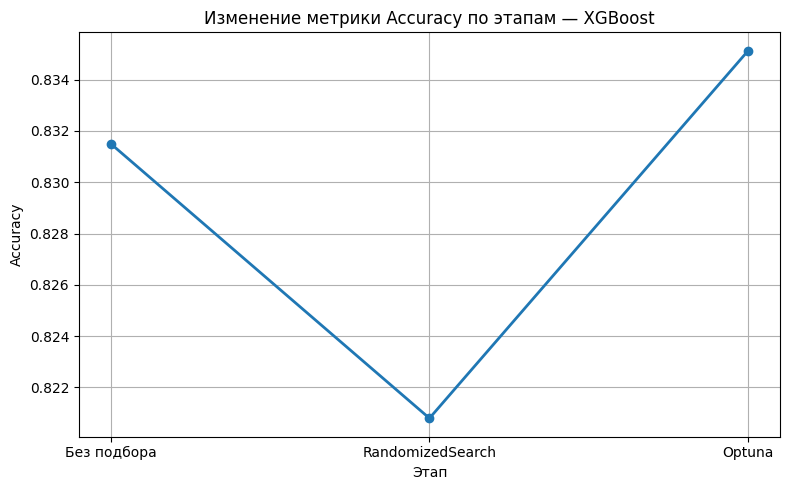

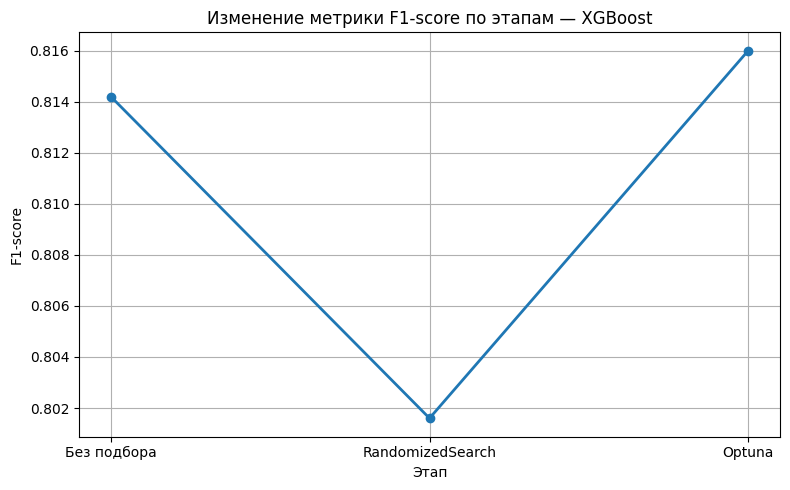

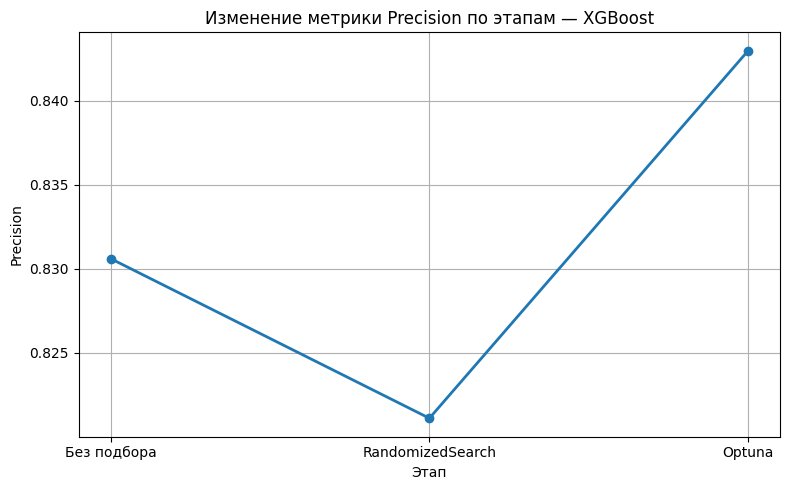

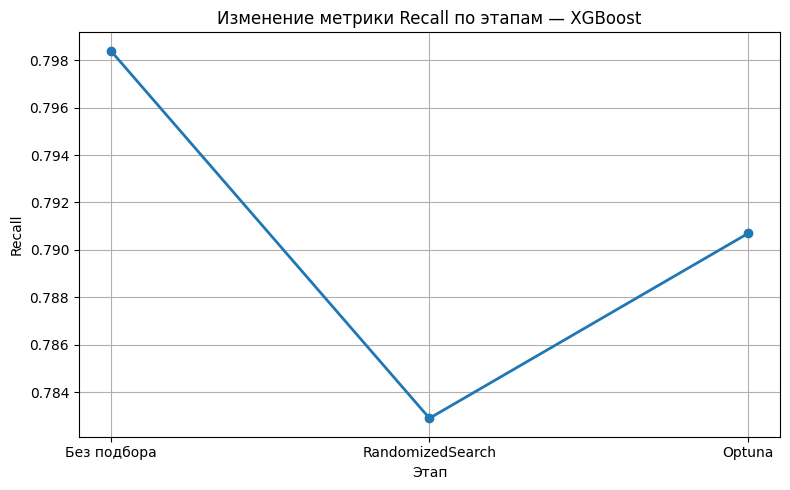

In [ ]:
target_model = best_model_name

# 1. Получаем базовую версию (без подбора)
base_row = all_results[(all_results['Model'] == target_model) & (all_results['Hyperparametres'] == False)].sort_values('Accuracy', ascending=False).iloc[0]

# 2. С RandomizedSearch
random_row = all_results[(all_results['Model'] == target_model) & (all_results['Hyperparametres'] == True)].sort_values('Accuracy', ascending=False).iloc[0]

# 3. Финальные метрики Optuna (берём из переменных после обучения)
optuna_metrics = {
    'Accuracy': final_accuracy,
    'F1-score': final_f1,
    'Precision': final_precision,
    'Recall': final_recall
}

# 4. Собираем всё в DataFrame
progress = pd.DataFrame({
    'Этап': ['Без подбора', 'RandomizedSearch', 'Optuna'],
    'Accuracy': [base_row['Accuracy'], random_row['Accuracy'], optuna_metrics['Accuracy']],
    'F1-score': [base_row['F1-score'], random_row['F1-score'], optuna_metrics['F1-score']],
    'Precision': [base_row['Precision'], random_row['Precision'], optuna_metrics['Precision']],
    'Recall': [base_row['Recall'], random_row['Recall'], optuna_metrics['Recall']],
})

# 5. Строим графики для каждой метрики
for metric in ['Accuracy', 'F1-score', 'Precision', 'Recall']:
    plt.figure(figsize=(8, 5))
    plt.plot(progress['Этап'], progress[metric], marker='o', linewidth=2)
    plt.title(f'Изменение метрики {metric} по этапам — {target_model}')
    plt.xlabel('Этап')
    plt.ylabel(metric)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Исходя из анализа, оптимальной моделью для классификации превышения медианного значения CC50 является XGBoost с настройкой гиперпараметров через Optuna. Модель демонстрирует высокую точность и сбалансированность между полнотой и точностью, что важно для надёжного предсказания.